In [39]:
%matplotlib inline
import numpy as np
import pandas as pd

units = 1000
time_steps = 52

Z = np.random.normal(size=units)

a_trend = np.arange(0, time_steps, 1)
individual_effects = Z
A_trend = np.tile(a_trend, units).reshape(units, time_steps)
A_indiv = np.tile(individual_effects, time_steps).reshape(time_steps, units).T
Y_0 = A_trend + A_indiv


In [40]:
# we have a linear time trend
a_trend

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])

In [41]:
A_trend # the same time trend for all units

array([[ 0,  1,  2, ..., 49, 50, 51],
       [ 0,  1,  2, ..., 49, 50, 51],
       [ 0,  1,  2, ..., 49, 50, 51],
       ...,
       [ 0,  1,  2, ..., 49, 50, 51],
       [ 0,  1,  2, ..., 49, 50, 51],
       [ 0,  1,  2, ..., 49, 50, 51]])

In [42]:
# we have individual offsets
individual_effects

array([-8.93253339e-01, -1.09666136e+00,  4.27353642e-01,  1.44520048e+00,
        4.38795580e-01,  8.96686700e-01,  1.62119252e+00, -1.30064478e-01,
       -4.43165568e-01, -2.04901639e+00, -1.54718680e+00,  1.40305500e+00,
        1.41225225e+00, -1.00809407e+00,  5.68498727e-02, -8.71405945e-01,
        2.42546781e-01, -3.07400432e+00, -3.85623050e-01, -1.58357690e-02,
        2.65091453e-02,  2.00074199e-01,  5.51215775e-02,  6.83305971e-01,
       -7.85775243e-01, -1.74420000e+00,  5.51176439e-01,  1.19879365e+00,
        3.32426382e-01, -1.06984475e+00, -2.30336948e-01,  2.66790330e-01,
        6.93669309e-01,  3.38674913e-01,  5.98768624e-01, -5.51166254e-01,
        6.57236613e-01, -7.31142267e-01, -9.25339620e-01,  5.81513510e-02,
        4.65697985e-02,  5.34033238e-01,  4.09487287e-01, -3.76007676e-01,
        9.45804019e-01,  1.38889499e+00, -1.22255234e+00, -2.48003678e-01,
       -2.40529171e-02, -5.90648158e-01,  1.28590070e+00, -1.14338493e+00,
       -5.20295164e-01,  

In [43]:
A_indiv # the same offset of all time (but different for each unit)

array([[-0.89325334, -0.89325334, -0.89325334, ..., -0.89325334,
        -0.89325334, -0.89325334],
       [-1.09666136, -1.09666136, -1.09666136, ..., -1.09666136,
        -1.09666136, -1.09666136],
       [ 0.42735364,  0.42735364,  0.42735364, ...,  0.42735364,
         0.42735364,  0.42735364],
       ...,
       [ 1.53075471,  1.53075471,  1.53075471, ...,  1.53075471,
         1.53075471,  1.53075471],
       [-1.44499589, -1.44499589, -1.44499589, ..., -1.44499589,
        -1.44499589, -1.44499589],
       [ 1.11394801,  1.11394801,  1.11394801, ...,  1.11394801,
         1.11394801,  1.11394801]])

The outcome is the sum of a time trend and individual effects.

In [44]:
# Now, we'll have the probability of being assigned to treatment depend on Z
p_d = 1. / (1. + np.exp(-Z))
D_star = np.random.binomial(1, p=p_d)

# We need the time-series treatment assignments now. The treatment turns on and
# stays on. Let's start by having them all turn on at the same time, to build some
# intuition. Then we'll turn them on at random times. 
#
# The assignment matrix has the same dimensions as the outcome matrix.

D = np.zeros(shape=Y_0.shape)
for i in range(units):
    for t in range(time_steps):
        if D_star[i] and t > 0:
            ## modify the remainder of this block to get random start times.
            if t == time_steps - 1 or D[i][t-1] == 1:
                D[i][t] = 1
            else:
                if t == int(float(time_steps) / 2.):
                    D[i][t] = 1  # np.random.binomial(1, p=1./float(time_steps))
                else:
                    D[i][t] = 0

In [45]:
# The treatment effect for each unit is a constant plus their Z, so we get confounding.
delta = 2.
Y_1 = Y_0 + delta + A_indiv
Y = (D==1)*Y_1 + (D==0)*Y_0

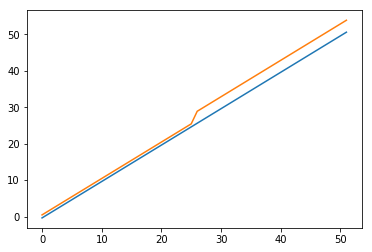

In [46]:
# Naive expected values

df = pd.DataFrame(Y)
df['$D^*$'] = D_star
d0 = df[df['$D^*$'] == 0]
d1 = df[df['$D^*$'] == 1]
del d0['$D^*$'], d1['$D^*$']
d0.mean(axis=0).plot()
d1.mean(axis=0).plot();

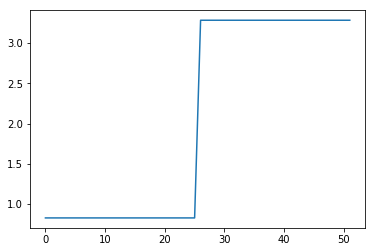

In [47]:
# Naive effect

# We have nobody in the test state before t=25, so we just get the
# Y_0 baseline difference between the D=1 and D=0 groups at t < 25.
# Afterward, we get the difference of E[Y_t|D=1] - E[Y_t|D=0]

df = pd.DataFrame(Y)
df['$D^*$'] = D_star
d0 = df[df['$D^*$'] == 0]
d1 = df[df['$D^*$'] == 1]
del d0['$D^*$'], d1['$D^*$']
(d1.T.mean(axis=1) - d0.T.mean(axis=1)).plot();


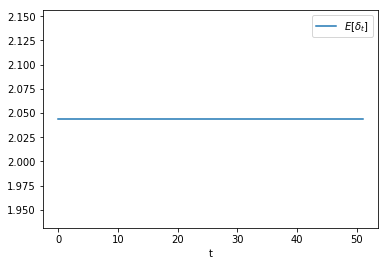

In [48]:
# True Effect

pd.DataFrame({'$E[\delta_t]$': (Y_1 - Y_0).mean(axis=0), 
              't': range(Y_0.shape[1])}).plot(x='t');

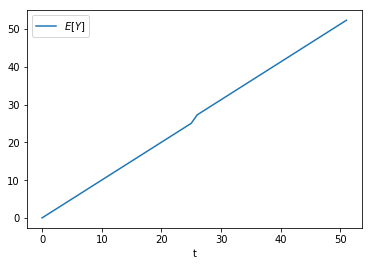

In [49]:
# For completeness, let's also check out the expected outcome over the whole population:

expected_outcome = Y.mean(axis=0)
pd.DataFrame({'$E[Y]$': expected_outcome, 't': range(expected_outcome.shape[0])}).plot(x='t');

In [50]:
# And the number of treated units vs. time:

D.sum(axis=0)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 505., 505., 505., 505., 505., 505., 505.,
       505., 505., 505., 505., 505., 505., 505., 505., 505., 505., 505.,
       505., 505., 505., 505., 505., 505., 505., 505.])

Now, we'll do propensity score matching on Z to match control units to test units to estimate the ATT. Since the confounding is constant with time, we can just match units (otherwise their propensities would vary over time, and matches might change!)

In [ ]:
# ... 